In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

In [2]:
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "./data", 
    validation_split=0.3,
    seed=123,
    subset="training")


validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "./data", 
    validation_split=0.3,
    seed=123,
    subset="validation")

Found 3852 files belonging to 4 classes.
Using 2697 files for training.
Found 3852 files belonging to 4 classes.
Using 1155 files for validation.


In [5]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [6]:
print("Number of training samples: %d" % tf.data.experimental.cardinality(train_dataset))
print(
    "Number of validation samples: %d" % tf.data.experimental.cardinality(validation_dataset)
)
print("Number of test samples: %d" % tf.data.experimental.cardinality(test_dataset))

Number of training samples: 1188
Number of validation samples: 408
Number of test samples: 102


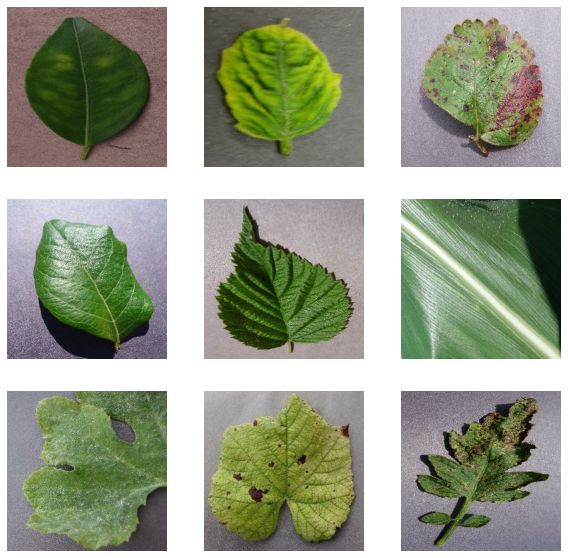

In [7]:

plt.figure(figsize=(10, 10))
for images, labels in test_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    # plt.title(class_names[labels[i]])
    plt.axis("off")

In [8]:
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [9]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

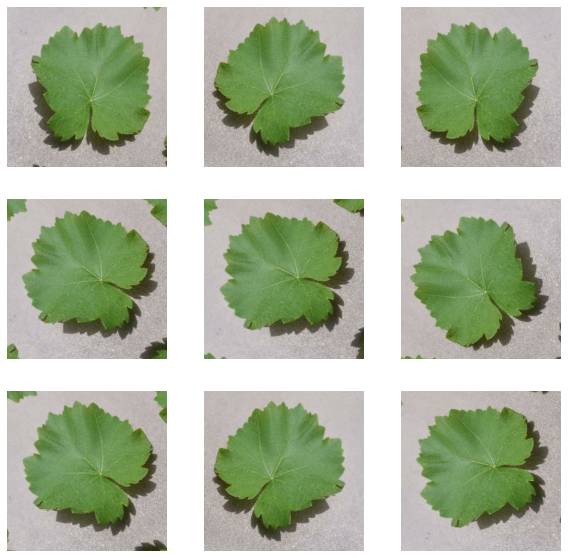

In [10]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')


In [11]:
# np_config.enable_numpy_behavior()
train_dataset.__repr__().split("(")[2].strip()



'None, 256, 256, 3),'

In [12]:
IMG_SHAPE = (256, 256) + (3,)
base_model = tf.keras.applications.EfficientNetB0(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')

In [13]:
IMG_SHAPE = (256, 256) + (3,)
base_model = tf.keras.applications.MobileNet(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')

In [14]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 8, 8, 1024)


In [15]:
base_model.trainable = False # Freeze the convolutional base


In [16]:
base_model.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 128, 128, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 128, 128, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 128, 128, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 128, 128, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 128, 128, 32)      128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 128, 128, 32

In [17]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)


(32, 1024)


In [18]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [19]:
inputs = tf.keras.Input(shape=(256, 256, 3))
x = data_augmentation(inputs)
# x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)


In [20]:
base_learning_rate = 0.01
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [27]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 256, 256, 3)       0         
_________________________________________________________________
mobilenet_1.00_224 (Function (None, 8, 8, 1024)        3228864   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1024)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1025      
Total params: 3,229,889
Trainable params: 1,025
Non-trainable params: 3,228,864
_______________________________________________

In [28]:
len(model.trainable_variables)

2

In [21]:
initial_epochs = 15

loss0, accuracy0 = model.evaluate(validation_dataset)

408/408 [==============================] - 2308s 5s/step - loss: -11.7184 - accuracy: 0.0164


In [22]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: -11.72
initial accuracy: 0.02


In [23]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
1188/1188 [==============================] - 2105s 2s/step - loss: -49293.3594 - accuracy: 0.0115 - val_loss: -97732.8672 - val_accuracy: 0.0112
Epoch 2/10
1188/1188 [==============================] - 9900s 8s/step - loss: -148391.8750 - accuracy: 0.0115 - val_loss: -195694.0469 - val_accuracy: 0.0113
Epoch 3/10
1188/1188 [==============================] - 2971s 3s/step - loss: -247483.2969 - accuracy: 0.0115 - val_loss: -293922.0625 - val_accuracy: 0.0114
Epoch 4/10
1188/1188 [==============================] - 2483s 2s/step - loss: -346596.6250 - accuracy: 0.0115 - val_loss: -391811.3750 - val_accuracy: 0.0112
Epoch 5/10
1188/1188 [==============================] - 1675s 1s/step - loss: -445702.5000 - accuracy: 0.0115 - val_loss: -489595.0625 - val_accuracy: 0.0114
Epoch 6/10
 771/1188 [==================>...........] - ETA: 8:27 - loss: -529431.1875 - accuracy: 0.0109

In [25]:

IMG_SHAPE = (256, 256) + (3,)
base_model_b = tf.keras.applications.EfficientNetB5(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')
IMG_SHAPE = (256, 256) + (3,)
base_model_res = tf.keras.applications.ResNet50V2(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')



94674944/94668760 [==============================] - 26s 0us/step


In [28]:

image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model_b(image_batch)

base_model_b.trainable = False

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)

prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)

inputs = tf.keras.Input(shape=(256, 256, 3))
x = data_augmentation(inputs)
# x = preprocess_input(x)
x = base_model_b(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model_b = tf.keras.Model(inputs, outputs)


In [32]:
base_learning_rate = 0.0001
model_b.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

initial_epochs = 10
loss0, accuracy0 = model_b.evaluate(validation_dataset)

24/24 [==============================] - 208s 8s/step - loss: 0.5430 - accuracy: 0.1394


In [33]:
history = model_b.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
85/85 [==============================] - 952s 11s/step - loss: -0.0994 - accuracy: 0.2562 - val_loss: -1.1385 - val_accuracy: 0.2801
Epoch 2/10
85/85 [==============================] - 818s 10s/step - loss: -1.4881 - accuracy: 0.3129 - val_loss: -2.3400 - val_accuracy: 0.2963
Epoch 3/10
85/85 [==============================] - 697s 8s/step - loss: -2.6336 - accuracy: 0.3155 - val_loss: -3.4944 - val_accuracy: 0.2950
Epoch 4/10
85/85 [==============================] - 701s 8s/step - loss: -3.7552 - accuracy: 0.3181 - val_loss: -4.8126 - val_accuracy: 0.2909
Epoch 5/10
85/85 [==============================] - 3652s 43s/step - loss: -4.8208 - accuracy: 0.3174 - val_loss: -5.7463 - val_accuracy: 0.3058
Epoch 6/10
85/85 [==============================] - 973s 11s/step - loss: -5.9296 - accuracy: 0.3178 - val_loss: -7.1125 - val_accuracy: 0.2950
Epoch 7/10
85/85 [==============================] - 893s 10s/step - loss: -7.0536 - accuracy: 0.3174 - val_loss: -7.8879 - val_accuracy: 

In [34]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model_res(image_batch)

base_model_res.trainable = False

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)

prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)

inputs = tf.keras.Input(shape=(256, 256, 3))
x = data_augmentation(inputs)
# x = preprocess_input(x)
x = base_model_res(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model_res = tf.keras.Model(inputs, outputs)

In [35]:
base_learning_rate = 0.0001
model_res.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

initial_epochs = 10
loss0, accuracy0 = model_res.evaluate(validation_dataset)

24/24 [==============================] - 87s 3s/step - loss: -102.5534 - accuracy: 0.2991


In [36]:
history = model_res.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
85/85 [==============================] - 409s 5s/step - loss: -199.7718 - accuracy: 0.3178 - val_loss: -327.9100 - val_accuracy: 0.2991
Epoch 2/10
85/85 [==============================] - 378s 4s/step - loss: -427.3069 - accuracy: 0.3178 - val_loss: -567.0107 - val_accuracy: 0.2882
Epoch 3/10
85/85 [==============================] - 390s 5s/step - loss: -659.8564 - accuracy: 0.3178 - val_loss: -819.0389 - val_accuracy: 0.2801
Epoch 4/10
85/85 [==============================] - 425s 5s/step - loss: -899.0597 - accuracy: 0.3178 - val_loss: -1047.2151 - val_accuracy: 0.2936
Epoch 5/10
85/85 [==============================] - 425s 5s/step - loss: -1127.7899 - accuracy: 0.3178 - val_loss: -1265.7744 - val_accuracy: 0.2977
Epoch 6/10
85/85 [==============================] - 406s 5s/step - loss: -1366.4351 - accuracy: 0.3178 - val_loss: -1444.1500 - val_accuracy: 0.3004
Epoch 7/10
85/85 [==============================] - 406s 5s/step - loss: -1593.4421 - accuracy: 0.3178 - val_loss

In [9]:

IMG_SHAPE = (256, 256) + (3,)
base_model_mobile_net = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')

In [13]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model_mobile_net(image_batch)

base_model_mobile_net.trainable = False

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)

prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)

inputs = tf.keras.Input(shape=(256, 256, 3))
x = data_augmentation(inputs)
# x = preprocess_input(x)
x = base_model_mobile_net(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model_mobile_net = tf.keras.Model(inputs, outputs)

In [14]:
base_learning_rate = 0.0001
model_mobile_net.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [21]:
initial_epochs = 10

loss0, accuracy0 = model_mobile_net.evaluate(validation_dataset)

30/30 [==============================] - 49s 1s/step - loss: -0.4111 - accuracy: 0.1515


In [15]:
history = model_mobile_net.fit(train_dataset.repeat(),
steps_per_epoch=18,
                    epochs=80,
                    validation_steps=3,
                    validation_data=validation_dataset)

Epoch 1/80
18/18 [==============================] - 38s 2s/step - loss: -1.0201 - accuracy: 0.3160 - val_loss: -1.3964 - val_accuracy: 0.2708
Epoch 2/80
18/18 [==============================] - 26s 1s/step - loss: -1.3729 - accuracy: 0.3420 - val_loss: -1.1321 - val_accuracy: 0.3333
Epoch 3/80
18/18 [==============================] - 28s 2s/step - loss: -1.9801 - accuracy: 0.2934 - val_loss: -2.5336 - val_accuracy: 0.2604
Epoch 4/80
18/18 [==============================] - 29s 2s/step - loss: -2.2970 - accuracy: 0.3125 - val_loss: -2.2257 - val_accuracy: 0.3021
Epoch 5/80
18/18 [==============================] - 26s 1s/step - loss: -2.9760 - accuracy: 0.3020 - val_loss: -2.8365 - val_accuracy: 0.3438
Epoch 6/80
18/18 [==============================] - 25s 1s/step - loss: -3.5578 - accuracy: 0.3542 - val_loss: -3.9976 - val_accuracy: 0.3021
Epoch 7/80
18/18 [==============================] - 25s 1s/step - loss: -3.7336 - accuracy: 0.3090 - val_loss: -3.6291 - val_accuracy: 0.3333
Epoch 

In [42]:
from tensorflow.keras import initializers

IMG_SHAPE = (256, 256) + (3,)
learning_rate = 0.0001

base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')

base_model.trainable = False


x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dense(1280, activation='relu',  kernel_initializer=initializers.glorot_uniform(0), bias_initializer='zeros')(x)
x = tf.keras.layers.BatchNormalization()(x)
predictions = tf.keras.layers.Dense(1, activation='softmax', kernel_initializer='random_uniform', bias_initializer='zeros')(x)

model = tf.keras.Model(inputs=base_model.input, outputs=predictions)
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
loss = "categorical_crossentropy"


model.compile(optimizer=optimizer,
              loss=loss,
              metrics=["accuracy"])

model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 128, 128, 32) 864         input_9[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 128, 128, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 128, 128, 32) 0           bn_Conv1[0][0]                   
____________________________________________________________________________________________

In [43]:
initial_epochs = 10
loss0, accuracy0 = model.evaluate(validation_dataset)

30/30 [==============================] - 51s 2s/step - loss: 0.0000e+00 - accuracy: 0.2975


In [50]:
from tensorflow.keras import initializers

IMG_SHAPE = (256, 256) + (3,)
learning_rate = 0.0001

resnet = tf.keras.applications.ResNet50V2(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')
for layer in resnet.layers[:-4]:
    layer.trainable = False

model = tf.keras.Sequential()

model.add(resnet)

model.add(tf.keras.layers.Dropout(0.5))
  
model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Dense(100, activation='elu'))
model.add(tf.keras.layers.Dropout(0.5))

model.add(tf.keras.layers.Dense(50, activation='elu'))
model.add(tf.keras.layers.Dropout(0.5))

model.add(tf.keras.layers.Dense(10, activation='elu'))
model.add(tf.keras.layers.Dropout(0.5))

model.add(tf.keras.layers.Dense(1))

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Functional)      (None, 8, 8, 2048)        23564800  
_________________________________________________________________
dropout_5 (Dropout)          (None, 8, 8, 2048)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 131072)            0         
_________________________________________________________________
dense_15 (Dense)             (None, 100)               13107300  
_________________________________________________________________
dropout_6 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 50)                5050      
_________________________________________________________________
dropout_7 (Dropout)          (None, 50)               

In [51]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

30/30 [==============================] - 156s 5s/step - loss: 2.0692e-07 - accuracy: 0.2685


In [13]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Sequential, load_model
import time

import tensorflow.keras
from tensorflow.keras import backend as K
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.applications import imagenet_utils
# from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt


start = time.time()


# loading the model
model = load_model(r'C:\Users\THINKPAD-E590\Projects\final_year_project\model\cropdisease-ml\model\model.h5')

In [17]:
def prepare_image(file):
    img = image.load_img(file, target_size=(244,244))
    img_array = image.img_to_array(img)
    img_array_expanded_dims = np.expand_dims(img_array, axis=0)
    return tensorflow.keras.applications.mobilenet.preprocess_input(img_array_expanded_dims)

In [21]:
preprocessed_image = prepare_image(r"data\Corn_(maize)___healthy\0b1610fa-438a-42e2-9ba2-274bb64a29ed___R.S_HL 8091 copy 2.jpg")
predictions = model.predict(preprocessed_image)
result = predictions.argmax(axis=1)

predicted : healthy [0.9999076]


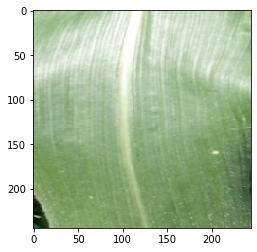

In [24]:
  if result == 0:
    print("predicted : leaf_spot", predictions[0][predictions.argmax(axis=1)])
    
  if result == 1:
    print("predicted : common_rust", predictions[0][predictions.argmax(axis=1)])

  if result == 2:
    print("predicted : leaf_blight", predictions[0][predictions.argmax(axis=1)])

  if result == 3:
    print("predicted : healthy", predictions[0][predictions.argmax(axis=1)])
img = image.load_img(r"data\Corn_(maize)___healthy\0b1610fa-438a-42e2-9ba2-274bb64a29ed___R.S_HL 8091 copy 2.jpg", target_size=(244,244))
plt.imshow(img)